In [407]:
import os
import numpy as np
import pandas as pd
import spark_sklearn as spk

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.clustering import GaussianMixture
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics

import matplotlib.pyplot as plt
import pyspark 
os.listdir('./')

['large-earth-flyover-animated-gif-1.gif',
 '.ipynb_checkpoints',
 'animate',
 'animate.py',
 'ddd.py',
 'download.gif',
 'eager.ipynb',
 'eager.py',
 'earth-spinning-rotating-animation-21-2.gif',
 'earth-spinning-rotating-animation-33.gif',
 'fdf.txt',
 'globalTextsSpark.py',
 'go-bt.gif',
 'gui.py',
 'ico',
 'iris.csv',
 'iris.csv.1',
 'iris.csv.2',
 'iris.csv.3',
 'iris.csv.4',
 'large-earth-flyover-animated-gif-2.gif',
 'loading-gear-3-2.gif',
 'loading-gear-4.gif',
 'loading-gear-6.gif',
 'loading1-1.gif',
 'logistic.ipynb',
 'money-animated-gif-13.gif',
 'pyspark_ratnesh.ipynb',
 'sample.txt',
 'spark-warehouse',
 'spark_demo.py',
 'spark_functions.py',
 'temp',
 'tkithread.py',
 'useless3cell.ipynb',
 'workload.zip',
 '__pycache__']

In [342]:
from pyspark import SparkContext,SparkConf
sc=SparkContext()

In [343]:
#!wget https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv

In [344]:
data=sc.textFile('./iris.csv')

In [345]:
type(data)

pyspark.rdd.RDD

In [346]:
data.take(5)

['sepal_length,sepal_width,petal_length,petal_width,species',
 '5.1,3.5,1.4,0.2,setosa',
 '4.9,3,1.4,0.2,setosa',
 '4.7,3.2,1.3,0.2,setosa',
 '4.6,3.1,1.5,0.2,setosa']

In [347]:
data.first()

'sepal_length,sepal_width,petal_length,petal_width,species'

In [348]:
from pyspark.sql import SparkSession, SQLContext

spark= SparkSession.builder \
    .master("local") \
    .appName("Data Exploration") \
    .getOrCreate()

In [349]:
#load data as Spark DataFrame
data2=spark.read.format("csv") \
    .option("header","true") \
    .option("mode","DROPMALFORMED") \
    .load('./iris.csv')

In [350]:
data2.count()

150

In [351]:
data2.show()

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|          3|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
|         4.6|        3.1|         1.5|        0.2| setosa|
|           5|        3.6|         1.4|        0.2| setosa|
|         5.4|        3.9|         1.7|        0.4| setosa|
|         4.6|        3.4|         1.4|        0.3| setosa|
|           5|        3.4|         1.5|        0.2| setosa|
|         4.4|        2.9|         1.4|        0.2| setosa|
|         4.9|        3.1|         1.5|        0.1| setosa|
|         5.4|        3.7|         1.5|        0.2| setosa|
|         4.8|        3.4|         1.6|        0.2| setosa|
|         4.8|          3|         1.4|        0.1| setosa|
|         4.3|          3|         1.1| 

In [352]:
data2.printSchema()

root
 |-- sepal_length: string (nullable = true)
 |-- sepal_width: string (nullable = true)
 |-- petal_length: string (nullable = true)
 |-- petal_width: string (nullable = true)
 |-- species: string (nullable = true)



In [353]:
cols =data2.columns

In [354]:
from pyspark.sql.functions import *

data2.select('sepal_length').agg(mean('sepal_length')).show()

+-----------------+
|avg(sepal_length)|
+-----------------+
|5.843333333333335|
+-----------------+



In [355]:
data2.select('sepal_length','species').groupby('species').agg(mean('sepal_length')).show()

+----------+-----------------+
|   species|avg(sepal_length)|
+----------+-----------------+
| virginica|6.587999999999998|
|versicolor|            5.936|
|    setosa|5.005999999999999|
+----------+-----------------+



In [356]:
from pyspark.mllib.classification import LinearModel, LogisticRegressionWithLBFGS
model = LinearModel([0.5,0.5],0.5)
model

(weights=[0.5,0.5], intercept=0.5)

In [357]:
model.intercept

0.5

In [358]:
data2 = data2.selectExpr('CAST(Sepal_Length AS INT) AS Sepal_Length','CAST(Petal_Width AS INT) AS Petal_Width','CAST(Sepal_Width AS INT) AS Sepal_Width','CAST(Petal_Length AS INT) AS Petal_Length','Species')

In [359]:
data2.printSchema()

root
 |-- Sepal_Length: integer (nullable = true)
 |-- Petal_Width: integer (nullable = true)
 |-- Sepal_Width: integer (nullable = true)
 |-- Petal_Length: integer (nullable = true)
 |-- Species: string (nullable = true)



In [360]:
p = data2.toPandas()

In [361]:
p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
Sepal_Length    150 non-null int64
Petal_Width     150 non-null int64
Sepal_Width     150 non-null int64
Petal_Length    150 non-null int64
Species         150 non-null object
dtypes: int64(4), object(1)
memory usage: 5.3+ KB


In [362]:
assembler = VectorAssembler(
    inputCols=data2.columns[:-1],
    outputCol="features")
output = assembler.transform(data2)

In [363]:
standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='features',
                              outputCol='std_features')
model = standardizer.fit(output)
output = model.transform(output)

In [364]:
output.describe().show()

+-------+------------------+------------------+------------------+------------------+---------+
|summary|      Sepal_Length|       Petal_Width|       Sepal_Width|      Petal_Length|  Species|
+-------+------------------+------------------+------------------+------------------+---------+
|  count|               150|               150|               150|               150|      150|
|   mean| 5.386666666666667|              0.86|2.6466666666666665|3.3066666666666666|     null|
| stddev|0.8417516624857599|0.7144716919918649|0.5326477696681351|1.7720676379998967|     null|
|    min|                 4|                 0|                 2|                 1|   setosa|
|    max|                 7|                 2|                 4|                 6|virginica|
+-------+------------------+------------------+------------------+------------------+---------+



In [365]:
indexer = StringIndexer(inputCol="Species", outputCol="label_idx")
indexed = indexer.fit(output).transform(output)

In [366]:
indexed.show(5)

+------------+-----------+-----------+------------+-------+-----------------+--------------------+---------+
|Sepal_Length|Petal_Width|Sepal_Width|Petal_Length|Species|         features|        std_features|label_idx|
+------------+-----------+-----------+------------+-------+-----------------+--------------------+---------+
|           5|          0|          3|           1| setosa|[5.0,0.0,3.0,1.0]|[-0.4593595521092...|      2.0|
|           4|          0|          3|           1| setosa|[4.0,0.0,3.0,1.0]|[-1.6473583937710...|      2.0|
|           4|          0|          3|           1| setosa|[4.0,0.0,3.0,1.0]|[-1.6473583937710...|      2.0|
|           4|          0|          3|           1| setosa|[4.0,0.0,3.0,1.0]|[-1.6473583937710...|      2.0|
|           5|          0|          3|           1| setosa|[5.0,0.0,3.0,1.0]|[-0.4593595521092...|      2.0|
+------------+-----------+-----------+------------+-------+-----------------+--------------------+---------+
only showing top 5 

In [367]:
data_new = indexed.select(['std_features', 'Species', 'label_idx'])
data_new.show(5)

+--------------------+-------+---------+
|        std_features|Species|label_idx|
+--------------------+-------+---------+
|[-0.4593595521092...| setosa|      2.0|
|[-1.6473583937710...| setosa|      2.0|
|[-1.6473583937710...| setosa|      2.0|
|[-1.6473583937710...| setosa|      2.0|
|[-0.4593595521092...| setosa|      2.0|
+--------------------+-------+---------+
only showing top 5 rows



In [368]:
pca = PCA(k=2, inputCol="std_features", outputCol="pca")
model = pca.fit(data_new)
transformed = model.transform(data_new)

In [369]:
transformed.show(3)

+--------------------+-------+---------+--------------------+
|        std_features|Species|label_idx|                 pca|
+--------------------+-------+---------+--------------------+
|[-0.4593595521092...| setosa|      2.0|[1.85704336448390...|
|[-1.6473583937710...| setosa|      2.0|[2.46937892624136...|
|[-1.6473583937710...| setosa|      2.0|[2.46937892624136...|
+--------------------+-------+---------+--------------------+
only showing top 3 rows



In [370]:
features = transformed.select('pca').rdd.map(lambda x: np.array(x))

In [371]:
gmm = GaussianMixture.train(features, k=2)
prd = gmm.predict(features).collect()
type(prd)

list

In [372]:
labels = data_new.select('label_idx').collect()
labels = data_new.select('label_idx').rdd.map(lambda r: r[0]).collect()

In [373]:
np.corrcoef(prd,labels)

array([[ 1.       , -0.8660254],
       [-0.8660254,  1.       ]])

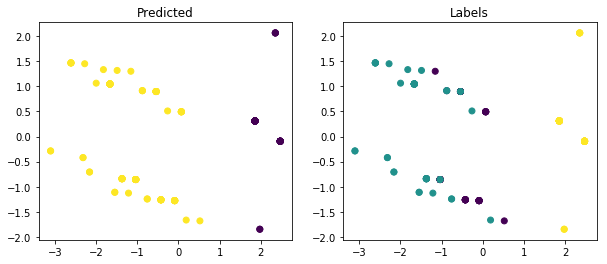

In [374]:
xs = np.array(features.collect()).squeeze()

fig, axes = plt.subplots(1, 2, figsize=(10, 4));
axes[0].scatter(xs[:, 0], xs[:,1], c=prd);
axes[0].set_title('Predicted');
axes[1].scatter(xs[:, 0], xs[:,1], c=labels)
axes[1].set_title('Labels');
plt.show()

In [375]:
data_new.show(5)

+--------------------+-------+---------+
|        std_features|Species|label_idx|
+--------------------+-------+---------+
|[-0.4593595521092...| setosa|      2.0|
|[-1.6473583937710...| setosa|      2.0|
|[-1.6473583937710...| setosa|      2.0|
|[-1.6473583937710...| setosa|      2.0|
|[-0.4593595521092...| setosa|      2.0|
+--------------------+-------+---------+
only showing top 5 rows



In [376]:
type(data_new),type(transformed),type(data)

(pyspark.sql.dataframe.DataFrame,
 pyspark.sql.dataframe.DataFrame,
 pyspark.rdd.RDD)

In [377]:
data7=sc.textFile('./iris.csv')

In [378]:
from pyspark.mllib import linalg as mllib_linalg
from pyspark.ml import linalg as ml_linalg

def as_old(v):
    if isinstance(v, ml_linalg.SparseVector):
        return mllib_linalg.SparseVector(v.size, v.indices, v.values)
    if isinstance(v, ml_linalg.DenseVector):
        return mllib_linalg.DenseVector(v.values)
    raise ValueError("Unsupported type {0}".format(type(v)))

In [379]:
data5= (transformed.select(col("label_idx").alias("label"), col("std_features"))
  .rdd
  .map(lambda row: LabeledPoint(row.label, as_old(row.std_features))))
data5.take(5)

[LabeledPoint(2.0, [-0.459359552109,-1.20368659758,0.663352694696,-1.30168093881]),
 LabeledPoint(2.0, [-1.64735839377,-1.20368659758,0.663352694696,-1.30168093881]),
 LabeledPoint(2.0, [-1.64735839377,-1.20368659758,0.663352694696,-1.30168093881]),
 LabeledPoint(2.0, [-1.64735839377,-1.20368659758,0.663352694696,-1.30168093881]),
 LabeledPoint(2.0, [-0.459359552109,-1.20368659758,0.663352694696,-1.30168093881])]

In [381]:
data4 = data_new.rdd.map(lambda x:  LabeledPoint(x[2],as_old(x[0])))
data4

PythonRDD[127] at RDD at PythonRDD.scala:48

In [382]:
training, test = data4.randomSplit([0.8, 0.2], seed=50)

In [383]:
training.count(),test.count()

(117, 33)

In [388]:
training.toLocalIterator()

In [389]:
model = LogisticRegressionWithLBFGS.train(sc.parallelize(training.toLocalIterator()), numClasses=3) # works OK

In [400]:
pred = test.map(lambda x: model.predict(x.features))
pred.take(15)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]

In [414]:
y_yhat = test.map(lambda x: (x.label, float(model.predict(x.features))))
err = y_yhat.filter(lambda x: x[0] != x[1]).count() / float(test.count())
print("Error = " + str(err))

Error = 0.030303030303030304


In [415]:
y_yhat.take(5)

[(2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0)]

In [417]:
# Instantiate metrics object
metrics = BinaryClassificationMetrics(y_yhat)

# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)


Area under PR = 0.9951515151515151
Area under ROC = 0.98


In [421]:

from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(y_yhat)

# Overall statistics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)


/media/ratnesh/SONGS/analytics/spark/python/pyspark/mllib/evaluation.py:237: UserWarning: Deprecated in 2.0.0. Use accuracy.
  warnings.warn("Deprecated in 2.0.0. Use accuracy.")


Summary Stats
Precision = 0.9696969696969697
Recall = 0.9696969696969697
F1 Score = 0.9696969696969697


/media/ratnesh/SONGS/analytics/spark/python/pyspark/mllib/evaluation.py:249: UserWarning: Deprecated in 2.0.0. Use accuracy.
  warnings.warn("Deprecated in 2.0.0. Use accuracy.")
/media/ratnesh/SONGS/analytics/spark/python/pyspark/mllib/evaluation.py:262: UserWarning: Deprecated in 2.0.0. Use accuracy.
  warnings.warn("Deprecated in 2.0.0. Use accuracy.")


In [424]:
# Statistics by class
labels = data_new.rdd.map(lambda lp: lp.label_idx).distinct().collect()
for label in sorted(labels):
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))

# Weighted stats
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

Class 0.0 precision = 0.8888888888888888
Class 0.0 recall = 1.0
Class 0.0 F1 Measure = 0.9411764705882353
Class 1.0 precision = 1.0
Class 1.0 recall = 0.9090909090909091
Class 1.0 F1 Measure = 0.9523809523809523
Class 2.0 precision = 1.0
Class 2.0 recall = 1.0
Class 2.0 F1 Measure = 1.0
Weighted recall = 0.9696969696969697
Weighted precision = 0.973063973063973
Weighted F(1) Score = 0.9698667345726169
Weighted F(0.5) Score = 0.9714254847944688
Weighted false positive rate = 0.009696969696969697


In [426]:
sc.stop()